In [1]:
#https://www.kaggle.com/code/alhsan/usedcars-eda-price-prediction
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor, HistGradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR, LinearSVR
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

from category_encoders import LeaveOneOutEncoder, TargetEncoder
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("used_cars_data.csv")
df.head()

S.No.                              Name    Location  Year  \
0      0            Maruti Wagon R LXI CNG      Mumbai  2010   
1      1  Hyundai Creta 1.6 CRDi SX Option        Pune  2015   
2      2                      Honda Jazz V     Chennai  2011   
3      3                 Maruti Ertiga VDI     Chennai  2012   
4      4   Audi A4 New 2.0 TDI Multitronic  Coimbatore  2013   

   Kilometers_Driven Fuel_Type Transmission Owner_Type     Mileage   Engine  \
0              72000       CNG       Manual      First  26.6 km/kg   998 CC   
1              41000    Diesel       Manual      First  19.67 kmpl  1582 CC   
2              46000    Petrol       Manual      First   18.2 kmpl  1199 CC   
3              87000    Diesel       Manual      First  20.77 kmpl  1248 CC   
4              40670    Diesel    Automatic     Second   15.2 kmpl  1968 CC   

       Power  Seats  New_Price  Price  
0  58.16 bhp    5.0        NaN   1.75  
1  126.2 bhp    5.0        NaN  12.50  
2   88.7 bhp    5.0  8.61 Lakh   4.50  
3  88.76 bhp    7.0        NaN   6.00  
4  140.8 bhp    5.0        NaN  17.74

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7253 entries, 0 to 7252
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   S.No.              7253 non-null   int64  
 1   Name               7253 non-null   object 
 2   Location           7253 non-null   object 
 3   Year               7253 non-null   int64  
 4   Kilometers_Driven  7253 non-null   int64  
 5   Fuel_Type          7253 non-null   object 
 6   Transmission       7253 non-null   object 
 7   Owner_Type         7253 non-null   object 
 8   Mileage            7251 non-null   object 
 9   Engine             7207 non-null   object 
 10  Power              7207 non-null   object 
 11  Seats              7200 non-null   float64
 12  New_Price          1006 non-null   object 
 13  Price              6019 non-null   float64
dtypes: float64(2), int64(3), object(9)
memory usage: 793.4+ KB


In [4]:
print(f"number of duplicate rows: {df.duplicated().sum()}")

number of duplicate rows: 0


In [5]:
print(f"Missing Values: \n{df.isnull().sum()}")

Missing Values: 
S.No.                   0
Name                    0
Location                0
Year                    0
Kilometers_Driven       0
Fuel_Type               0
Transmission            0
Owner_Type              0
Mileage                 2
Engine                 46
Power                  46
Seats                  53
New_Price            6247
Price                1234
dtype: int64


In [6]:
df.drop("New_Price", axis=1, inplace=True)
df.dropna(inplace=True)

### Name Edit

In [7]:
df["Brand"] = df.Name.apply(lambda x: x.split()[0])
df["Model"] = df.Name.apply(lambda x: " ".join(x.split(" ")[1:]))

In [8]:
df.head(3)

S.No.                              Name Location  Year  Kilometers_Driven  \
0      0            Maruti Wagon R LXI CNG   Mumbai  2010              72000   
1      1  Hyundai Creta 1.6 CRDi SX Option     Pune  2015              41000   
2      2                      Honda Jazz V  Chennai  2011              46000   

  Fuel_Type Transmission Owner_Type     Mileage   Engine      Power  Seats  \
0       CNG       Manual      First  26.6 km/kg   998 CC  58.16 bhp    5.0   
1    Diesel       Manual      First  19.67 kmpl  1582 CC  126.2 bhp    5.0   
2    Petrol       Manual      First   18.2 kmpl  1199 CC   88.7 bhp    5.0   

   Price    Brand                     Model  
0   1.75   Maruti           Wagon R LXI CNG  
1  12.50  Hyundai  Creta 1.6 CRDi SX Option  
2   4.50    Honda                    Jazz V

### Mileage Edit
<div class="alert alert-block alert-success"><b></b>Fuel consumption values are given in two different units such as km/kg and kmpl. These two units represent different units of measurement. Therefore, it is necessary to convert the fuel consumption in "km/kg" to "kmpl".

When the lines given in km/kg are filtered, it will be observed that all vehicles use LPG and CNG as fuel types. </div>

<div class="alert alert-block alert-success"><b></b>

* 1 kg of CNG is equivalent to 1.33 liters of gasoline or 1.22 liters of diesel. 1 liter of CNG is 0.750 kg.

* 1 liter of LPG is approximately 0.502 kg, 1 kg of LPG is 1.992 liters.

* For LPG; value * 1.992 = Distance traveled with 1 liter LPG (kmpl)

* For CNG; value * 1.33 = Distance traveled with 1 liter CNG (kmpl) </div>

In [9]:
df["Mileage_type"] = df.Mileage.apply(lambda x: str(x).split()[-1])
df["Mileage"] = df.Mileage.apply(lambda x: str(x).split()[0]).astype("float64")

In [10]:
df.loc[df.Fuel_Type == "LPG", "Mileage"] = df[df.Fuel_Type == "LPG"]["Mileage"].apply(lambda x: x * 1.992)
df.loc[df.Fuel_Type == "CNG", "Mileage"] = df[df.Fuel_Type == "CNG"]["Mileage"].apply(lambda x: x * 1.33)

* **Some of the Mileage variable values are entered as 0.**

In [11]:
# example
df[df.Mileage == 0][:2]

S.No.                                      Name    Location  Year  \
14     14            Land Rover Freelander 2 TD4 SE        Pune  2012   
67     67  Mercedes-Benz C-Class Progressive C 220d  Coimbatore  2019   

    Kilometers_Driven Fuel_Type Transmission Owner_Type  Mileage   Engine  \
14              85000    Diesel    Automatic     Second      0.0  2179 CC   
67              15369    Diesel    Automatic      First      0.0  1950 CC   

      Power  Seats  Price          Brand                       Model  \
14  115 bhp    5.0  17.50           Land   Rover Freelander 2 TD4 SE   
67  194 bhp    5.0  35.67  Mercedes-Benz  C-Class Progressive C 220d   

   Mileage_type  
14         kmpl  
67         kmpl

In [12]:
df.loc[df.Mileage == 0, "Mileage"] = np.nan
df.dropna(inplace=True)
df.drop("Mileage_type", axis=1, inplace=True)

In [13]:
df.head(3)

S.No.                              Name Location  Year  Kilometers_Driven  \
0      0            Maruti Wagon R LXI CNG   Mumbai  2010              72000   
1      1  Hyundai Creta 1.6 CRDi SX Option     Pune  2015              41000   
2      2                      Honda Jazz V  Chennai  2011              46000   

  Fuel_Type Transmission Owner_Type  Mileage   Engine      Power  Seats  \
0       CNG       Manual      First   35.378   998 CC  58.16 bhp    5.0   
1    Diesel       Manual      First   19.670  1582 CC  126.2 bhp    5.0   
2    Petrol       Manual      First   18.200  1199 CC   88.7 bhp    5.0   

   Price    Brand                     Model  
0   1.75   Maruti           Wagon R LXI CNG  
1  12.50  Hyundai  Creta 1.6 CRDi SX Option  
2   4.50    Honda                    Jazz V

### Engine/Power Edit

In [14]:
df["Engine"] = df.Engine.apply(lambda x: str(x).split()[0]).astype("float64")
df["Power"] = df.Power.apply(lambda x: str(x).split()[0])

In [15]:
# Some of the power values are given as null.

df.loc[df.Power == "null", "Power"] = np.nan
df.dropna(axis=0, inplace=True)
df["Power"] = df.Power.astype("float64")

In [16]:
df.drop(["S.No.", "Name"], axis=1, inplace=True)
df.reset_index(drop=True, inplace=True)

In [17]:
df.describe()

Year  Kilometers_Driven      Mileage       Engine        Power  \
count  5844.000000       5.844000e+03  5844.000000  5844.000000  5844.000000   
mean   2013.481006       5.832696e+04    18.477735  1622.834531   113.139612   
std       3.163546       9.235508e+04     4.519011   598.989657    53.812210   
min    1998.000000       1.710000e+02     6.400000   624.000000    34.200000   
25%    2012.000000       3.349325e+04    15.300000  1198.000000    75.000000   
50%    2014.000000       5.256450e+04    18.480000  1495.000000    94.680000   
75%    2016.000000       7.241450e+04    21.100000  1984.000000   138.100000   
max    2019.000000       6.500000e+06    52.190400  5998.000000   560.000000   

             Seats        Price  
count  5844.000000  5844.000000  
mean      5.285079     9.545515  
std       0.806768    11.187139  
min       2.000000     0.440000  
25%       5.000000     3.517500  
50%       5.000000     5.705000  
75%       5.000000    10.000000  
max      10.000000   160.000000

## Distributions of Categorical Features

In [18]:
loc_count = df.Location.value_counts()
year_count = df.Year.value_counts()
Fuel_Type_count = df.groupby("Fuel_Type")["Fuel_Type"].count()
Transmission_count = df.Transmission.value_counts()
Owner_Type_count = df.groupby("Owner_Type")["Owner_Type"].count()
Brand_count = df.Brand.value_counts()

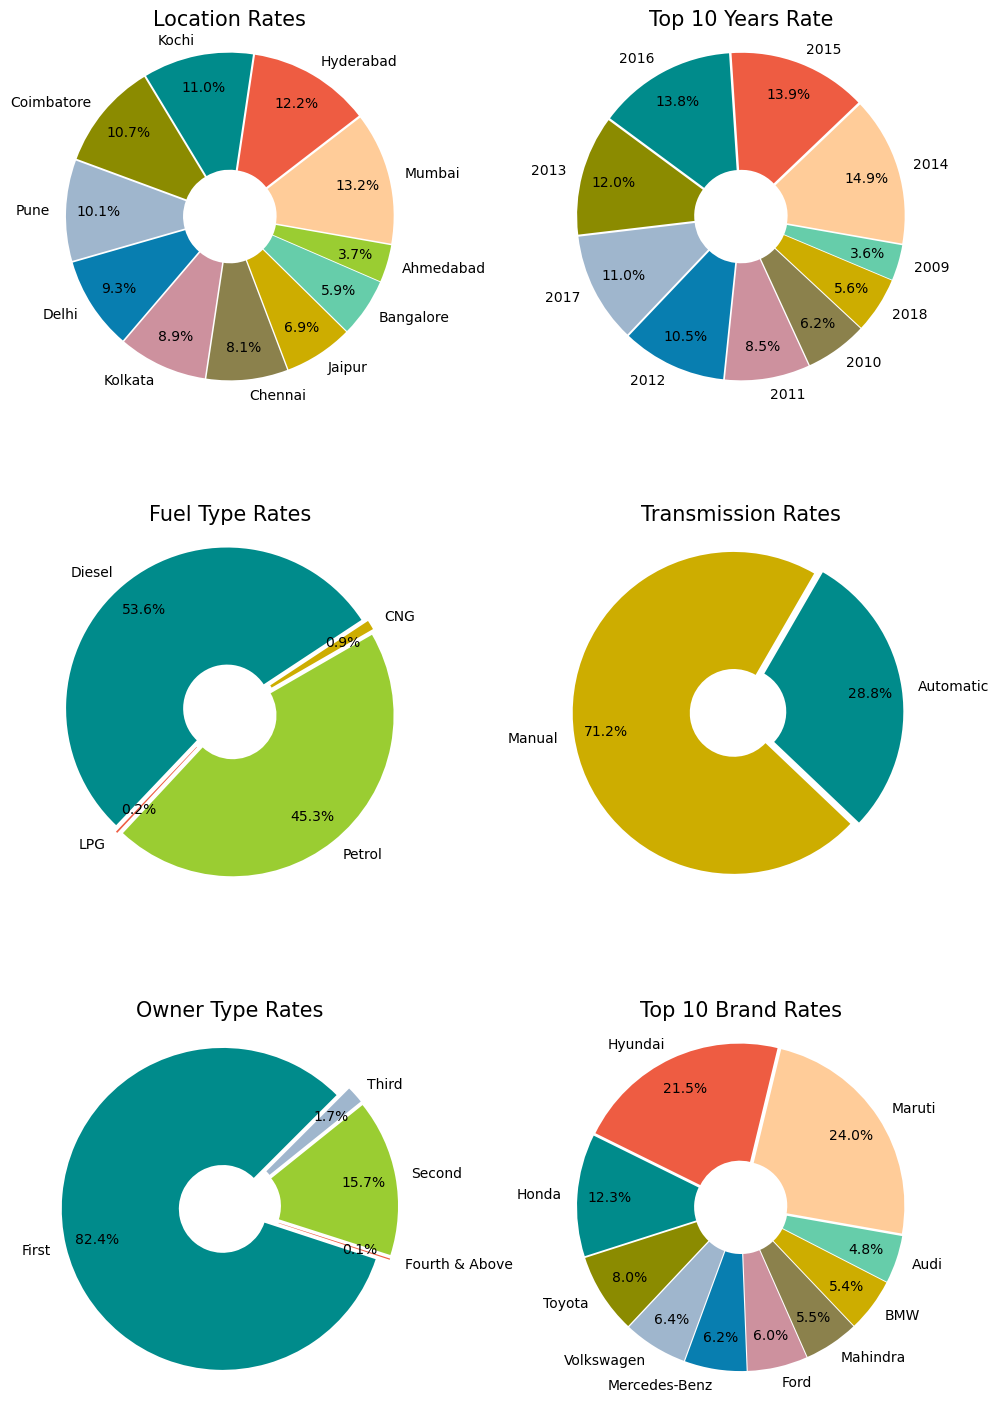

In [19]:
plt.figure(figsize=(10,15))
plt.subplot(3,2,1)
clr1 = ["#ffcc99", "#ee5c42", "#008b8b", "#8b8b00", "#9fb6cd", "#087EB0", "#cd919e", "#8b814c", "#cdad00", "#66cdaa", "#9acd32"]
plt.pie(x=loc_count, autopct="%.1f%%", pctdistance=0.8, labels=loc_count.index, colors=clr1, startangle=-10,
        radius=1.4-0.3, wedgeprops=dict(width=0.8), explode=[0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02])
plt.title("Location Rates", fontsize=15)
plt.subplot(3,2,2)
plt.pie(x=year_count[:10], autopct="%.1f%%", pctdistance=0.8, labels=year_count.index[:10], colors=clr1, startangle=-10,
        radius=1.4-0.3, wedgeprops=dict(width=0.8), explode=[0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02])
plt.title("Top 10 Years Rate", fontsize=15)
plt.subplot(3,2,3)
clr2 = ["#cdad00", "#008b8b", "#ee5c42", "#9acd32", "#9fb6cd", "#087EB0", "#cd919e", "#8b814c", "#66cdaa", "#9acd32"]
plt.pie(x=Fuel_Type_count, autopct="%.1f%%", pctdistance=0.8, labels=Fuel_Type_count.index, colors=clr2, startangle=30,
        radius=1.4-0.3, wedgeprops=dict(width=0.8), explode=[0.03,0.03,0.03,0.03])
plt.title("Fuel Type Rates", fontsize=15)
plt.subplot(3,2,4)
plt.pie(x=Transmission_count, autopct="%.1f%%", pctdistance=0.8, labels=Transmission_count.index, colors=clr2, startangle=60,
        radius=1.4-0.3, wedgeprops=dict(width=0.8), explode=[0.05,0.01])
plt.title("Transmission Rates", fontsize=15)
plt.subplot(3,2,5)
clr3 = ["#008b8b", "#ee5c42", "#9acd32", "#9fb6cd"]
plt.pie(x=Owner_Type_count, autopct="%.1f%%", pctdistance=0.8, labels=Owner_Type_count.index, colors=clr3, startangle=45,
        radius=1.4-0.3, wedgeprops=dict(width=0.8), explode=[0.05,0.05,0.05,0.05])
plt.title("Owner Type Rates", fontsize=15)
plt.subplot(3,2,6)
clr4 = ["#ffcc99", "#ee5c42", "#008b8b", "#8b8b00", "#9fb6cd", "#087EB0", "#cd919e", "#8b814c", "#cdad00", "#66cdaa", "#9acd32"]
plt.pie(x=Brand_count[:10], autopct="%.1f%%", pctdistance=0.8, labels=Brand_count.index[:10], colors=clr4, startangle=-10,
        radius=1.4-0.3, wedgeprops=dict(width=0.8), explode=[0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02])
plt.title("Top 10 Brand Rates", fontsize=15)
plt.tight_layout()
plt.show()

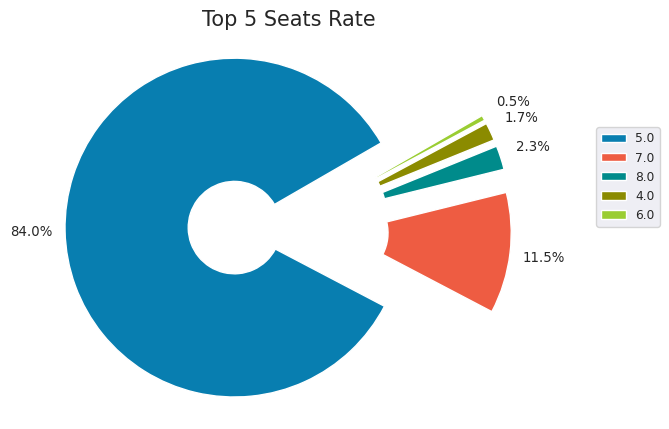

In [20]:
Seats_count = df.Seats.value_counts()

plt.figure(figsize=(6,5))
sns.set(font_scale = 0.8)
clr2 = ["#087EB0", "#ee5c42", "#008b8b", "#8b8b00", "#9acd32"]
plt.pie(x=Seats_count.values[:5], colors=clr2, startangle=30, autopct="%.1f%%", pctdistance=1.2, 
        radius=1.4-0.3, wedgeprops=dict(width=0.8), explode=[0.35,0.35,0.35,0.35,0.35])
plt.title("Top 5 Seats Rate", fontsize=15)
plt.legend(labels=Seats_count.index[:5], loc=(1.3, 0.5))
plt.show()

In [21]:
filter_brand = df.groupby(["Brand", "Model"])["Model"].count()
filter_brand = filter_brand.reset_index(name="counts").sort_values(by="counts", ascending=False)

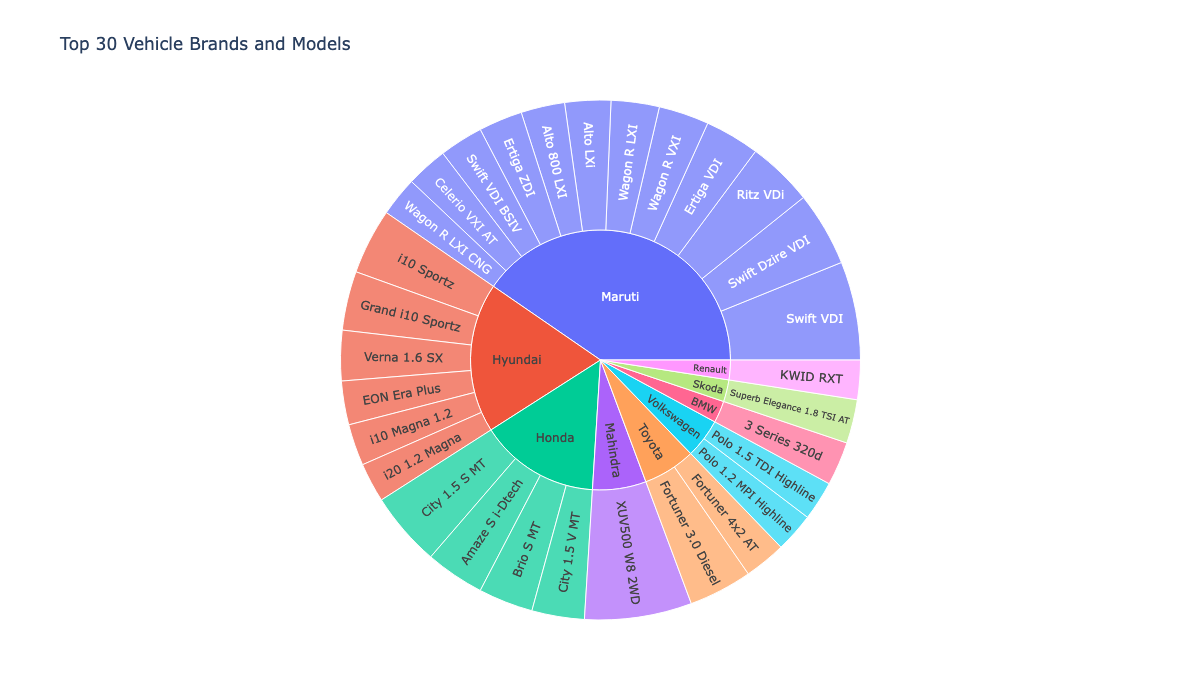

In [22]:
fig = px.sunburst(data_frame=filter_brand[:30], path=["Brand", "Model"], values="counts", height=700, width=700,
                 title="Top 30 Vehicle Brands and Models")
fig.show()

### Examination of Numerical Variables in Terms of Outliers
> ### Kilometers_Driven

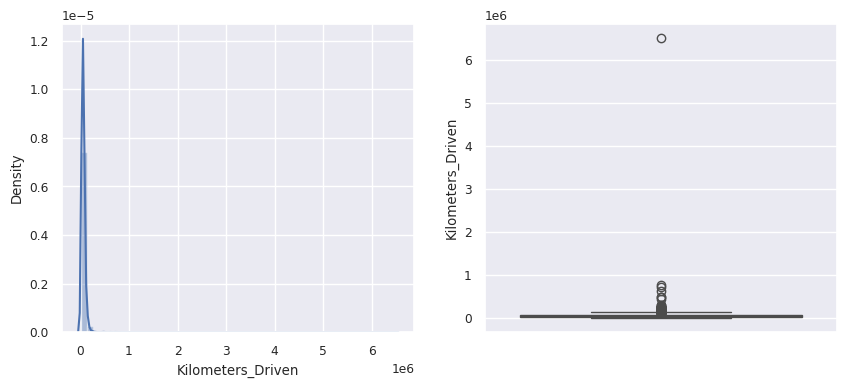

In [23]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.distplot(df.Kilometers_Driven)
plt.subplot(1,2,2)
sns.boxplot(df.Kilometers_Driven)
plt.show()

<div class="alert alert-block alert-success"><b></b>From the graphs above, it is observed that there are outliers in the mileage feature.
With the winsorizing method for outliers, we can prevent data loss by fitting the lowest and highest values in the data set into a certain percentage range. Or, we can remove outlier values by trimming the lowest and highest percentiles of the data set with the trimming method.

The choice is yours, but I will use the second method. </div>

In [24]:
df = df[(df['Kilometers_Driven'] >= df['Kilometers_Driven'].quantile(0.03)) & (df['Kilometers_Driven'] <= df['Kilometers_Driven'].quantile(0.97))]

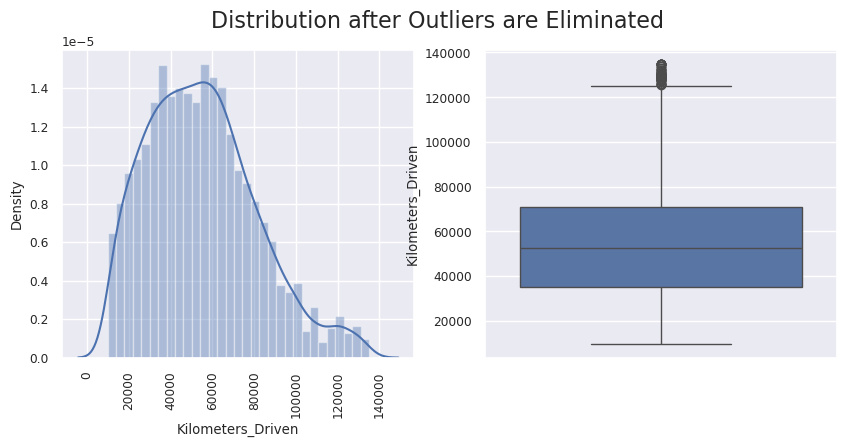

In [25]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.distplot(df.Kilometers_Driven)
plt.xticks(rotation=90)
plt.subplot(1,2,2)
sns.boxplot(df.Kilometers_Driven)
plt.suptitle("Distribution after Outliers are Eliminated", fontsize=16)
plt.show()

> ### Mileage

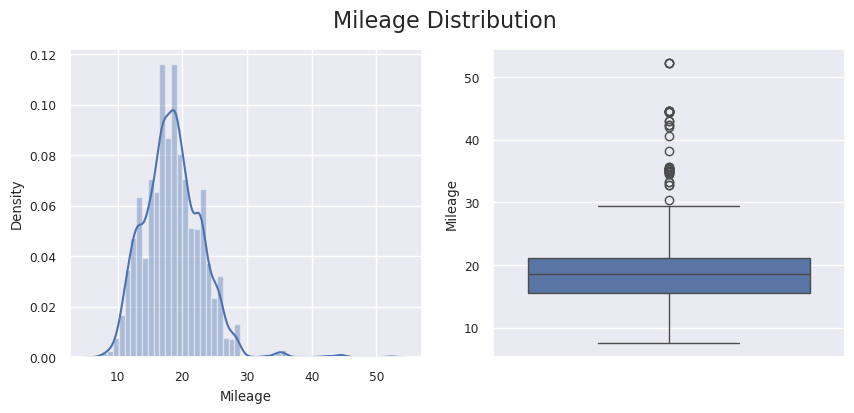

In [26]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.distplot(df.Mileage)
plt.subplot(1,2,2)
sns.boxplot(df.Mileage)
plt.suptitle("Mileage Distribution", fontsize=16)
plt.show()

<div class="alert alert-block alert-success"><b></b>When the Mileage feature is examined carefully, it will be seen that all of the vehicles with the upper outlier values are vehicles with LPG and CNG fuel types. It would be wrong to consider these as outliers. Because the energy efficiency of gasoline and diesel fuels is higher than LPG and CNG. for example; For the distance covered with 1 liter of gasoline, it is necessary to use more than 1 liter of LPG fuel. </div>

<div class="alert alert-block alert-success"><b></b> 
    
    * Gasoline 0.735 Kg/lt, calorific value 10.400 kCal
    
    * Diesel oil 0.830 Kg/lt, calorific value 10.200 kCal
    
    * CNG 0.670 Kg/m³, calorific value 8.250 kCal
    
    * LPG 2.477 Kg/m³, calorific value 27.000 kCal</div>

In [27]:
df[df.Mileage > 30]["Fuel_Type"].value_counts()

CNG    41
LPG     7
Name: Fuel_Type, dtype: int64

> ### Engine

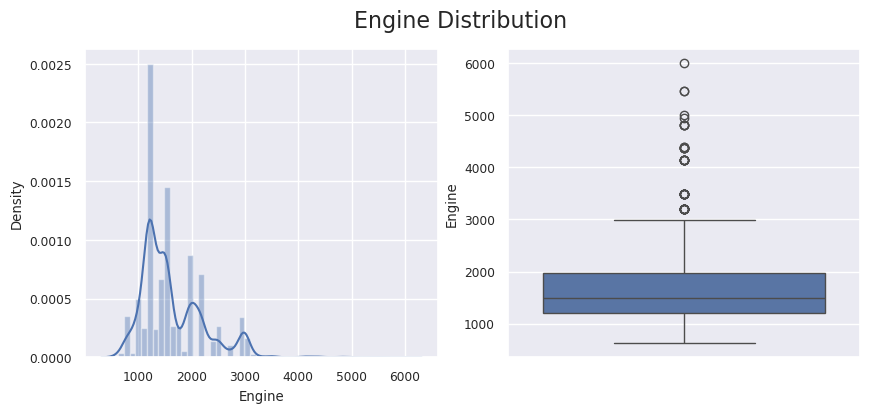

In [28]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.distplot(df.Engine)
plt.subplot(1,2,2)
sns.boxplot(df.Engine)
plt.suptitle("Engine Distribution", fontsize=16)
plt.show()

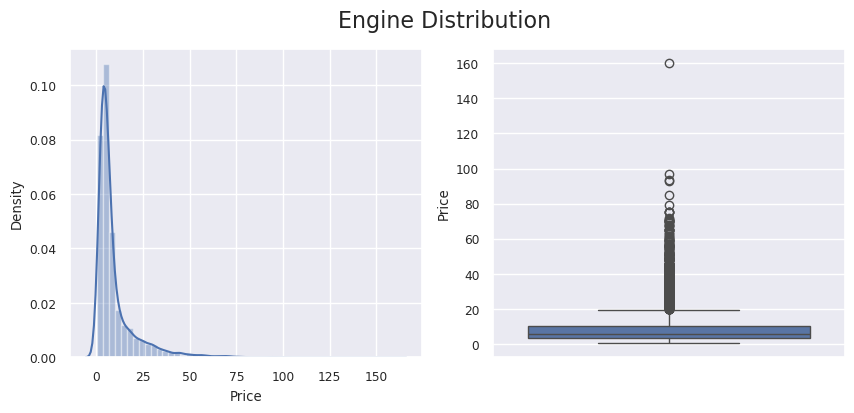

In [29]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.distplot(df.Price)
plt.subplot(1,2,2)
sns.boxplot(df.Price)
plt.suptitle("Engine Distribution", fontsize=16)
plt.show()

In [30]:
df = df[df.Price < 100]
df.reset_index(drop=True, inplace=True)

### Relationship Between Variables and Price

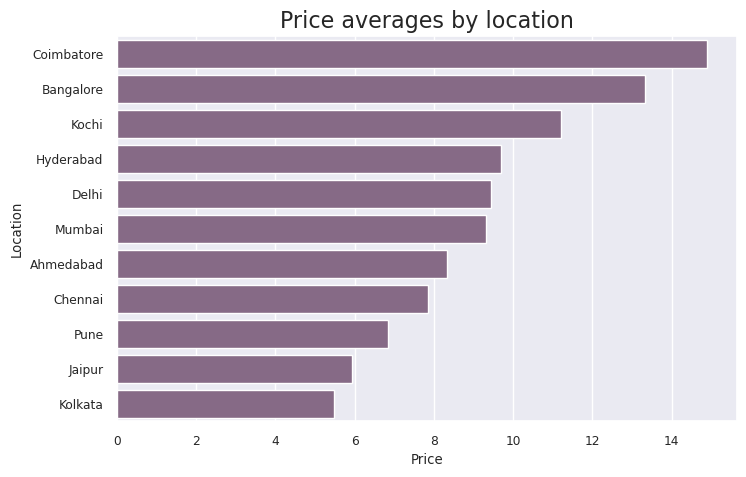

In [31]:
location_price = df.groupby("Location").agg({"Price": "mean"}).reset_index()
location_price = location_price.sort_values(by="Price", ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x=location_price.Price, y=location_price.Location, color="#8b658b")
plt.title("Price averages by location", fontsize=16)
plt.show()

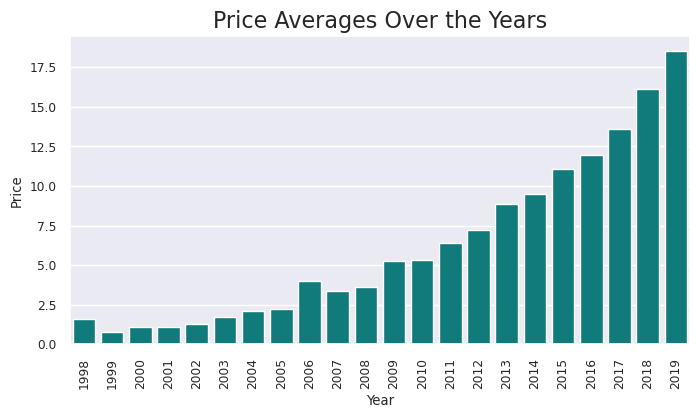

In [32]:
year_price = df.groupby("Year").agg({"Price": "mean"}).reset_index()
year_price = year_price.sort_values(by="Price", ascending=False)

plt.figure(figsize=(8,4))
sns.barplot(x=year_price.Year, y=year_price.Price, color="#008b8b")
plt.title("Price Averages Over the Years", fontsize=16)
plt.xticks(rotation=90)
plt.show()

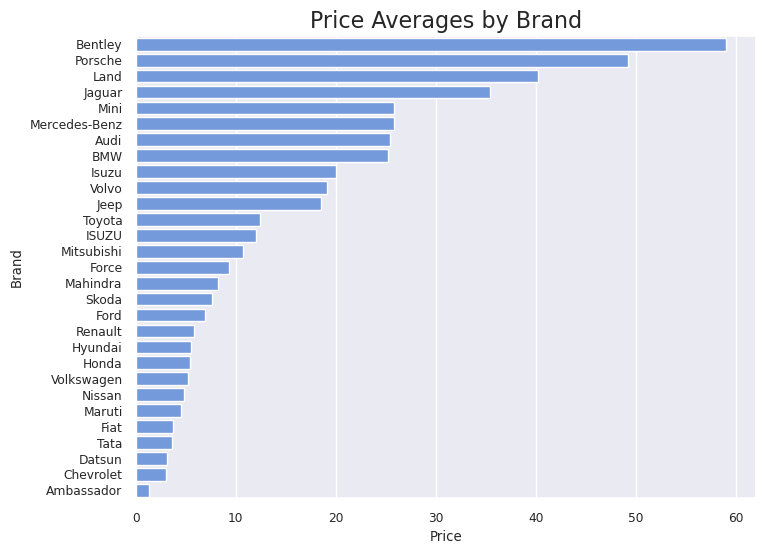

In [33]:
brand_price = df.groupby("Brand").agg({"Price": "mean"}).reset_index()
brand_price = brand_price.sort_values(by="Price", ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(x=brand_price.Price, y=brand_price.Brand, color="#6495ed")
plt.title("Price Averages by Brand", fontsize=16)
plt.show()

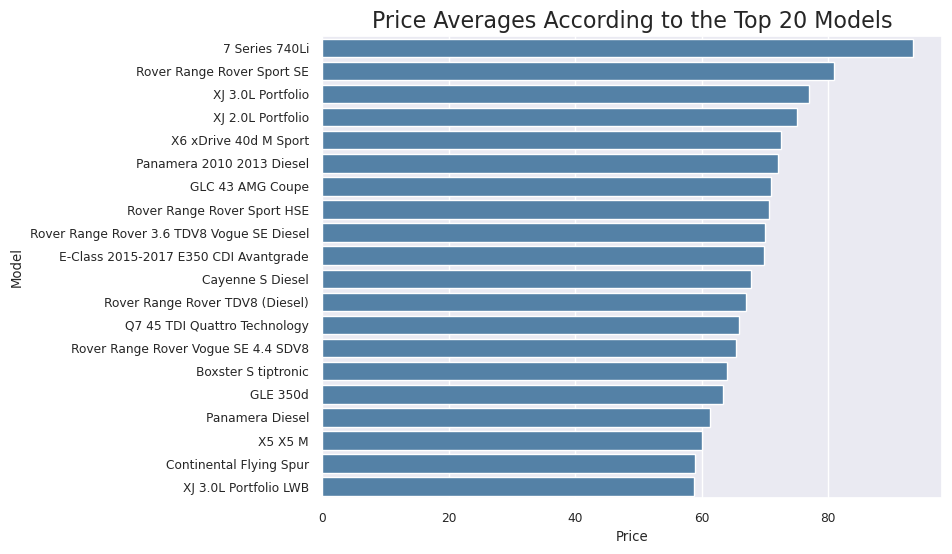

In [34]:
model_price = df.groupby("Model").agg({"Price": "mean"}).reset_index()
model_price = model_price.sort_values(by="Price", ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(x=model_price.Price[:20], y=model_price.Model[:20], color="#4682b4")
plt.title("Price Averages According to the Top 20 Models", fontsize=16)
plt.show()

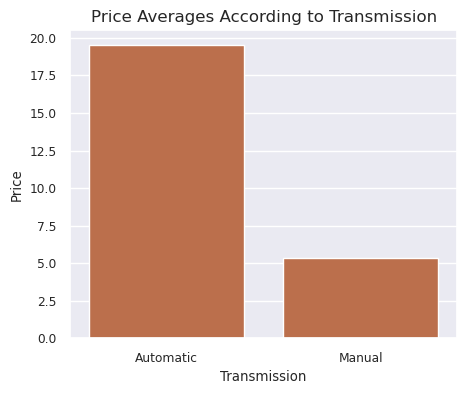

In [35]:
trans_price = df.groupby("Transmission").agg({"Price": "mean"}).reset_index()
trans_price = trans_price.sort_values(by="Price", ascending=False)

plt.figure(figsize=(5,4))
sns.barplot(x=trans_price.Transmission, y=trans_price.Price, color="#cd6839")
plt.title("Price Averages According to Transmission", fontsize=12)
plt.show()

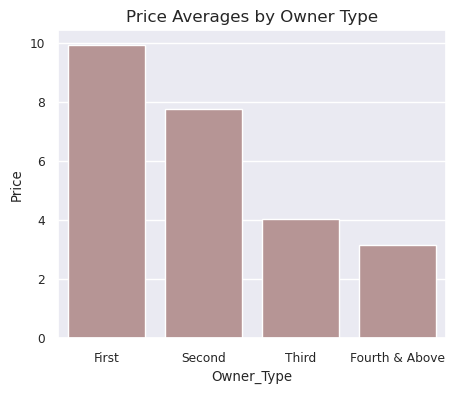

In [36]:
owner_type_price = df.groupby("Owner_Type").agg({"Price": "mean"}).reset_index()
owner_type_price = owner_type_price.sort_values(by="Price", ascending=False)

plt.figure(figsize=(5,4))
sns.barplot(x=owner_type_price.Owner_Type, y=owner_type_price.Price, color="#bc8f8f")
plt.title("Price Averages by Owner Type", fontsize=12)
plt.show()

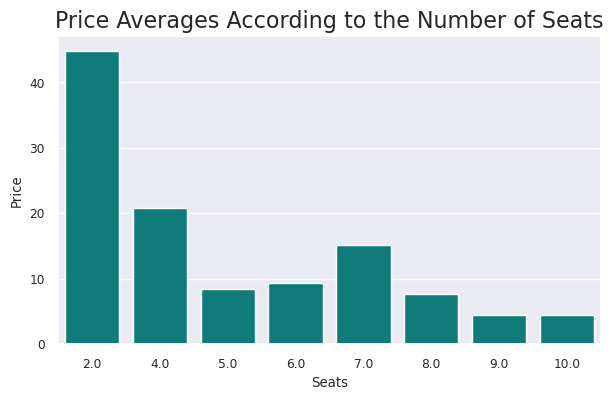

In [37]:
seat_price = df.groupby("Seats").agg({"Price": "mean"}).reset_index()
seat_price = seat_price.sort_values(by="Price", ascending=False)

plt.figure(figsize=(7,4))
sns.barplot(x=seat_price.Seats, y=seat_price.Price, color="#008b8b")
plt.title("Price Averages According to the Number of Seats", fontsize=16)
plt.show()

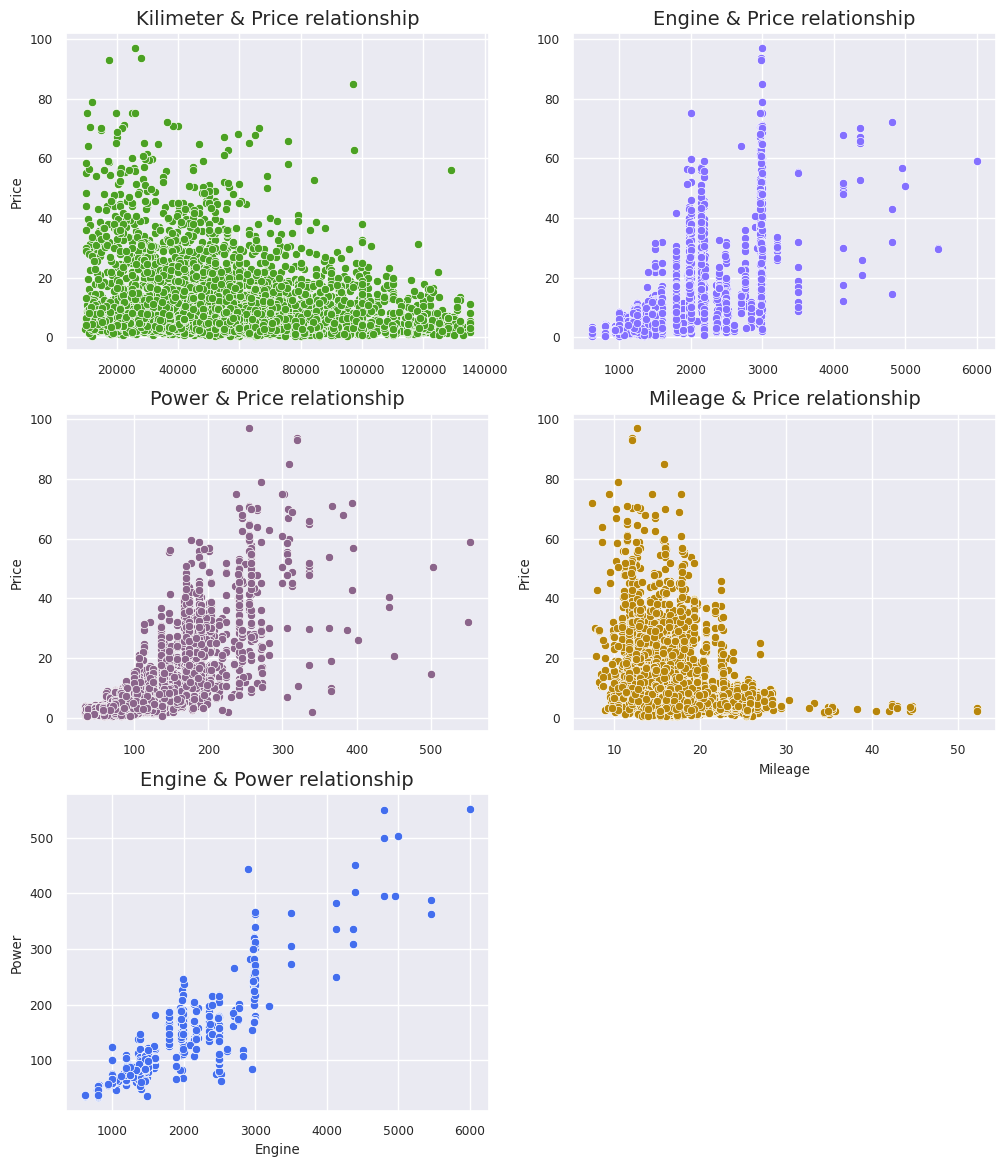

In [38]:
plt.figure(figsize=(12,14))
plt.subplot(3,2,1)
sns.scatterplot(x=df.Kilometers_Driven, y=df.Price, color="#4ba123")
plt.title("Kilimeter & Price relationship", fontsize=14)
plt.xlabel("\n")
plt.subplot(3,2,2)
sns.scatterplot(x=df.Engine, y=df.Price, color="#8470ff")
plt.title("Engine & Price relationship", fontsize=14)
plt.xlabel("\n"), plt.ylabel("")
plt.subplot(3,2,3)
sns.scatterplot(x=df.Power, y=df.Price, color="#8b658b")
plt.title("Power & Price relationship", fontsize=14)
plt.xlabel("")
plt.subplot(3,2,4)
sns.scatterplot(x=df.Mileage, y=df.Price, color="#b8860b")
plt.title("Mileage & Price relationship", fontsize=14)
plt.subplot(3,2,5)
sns.scatterplot(x=df.Engine, y=df.Power, color="#436eee")
plt.title("Engine & Power relationship", fontsize=14)
plt.show()

### Relationship of fuel type with other variables

In [39]:
fuel_type_filter = df.groupby("Fuel_Type").agg({"Price": "mean", "Engine": "mean", "Power": "mean"}).reset_index()
fuel_type_filter

Fuel_Type      Price       Engine       Power
0       CNG   3.558909  1091.145455   64.830909
1    Diesel  12.946201  1851.822252  128.288345
2       LPG   2.487000  1027.400000   59.915000
3    Petrol   5.557518  1352.045601   96.733826

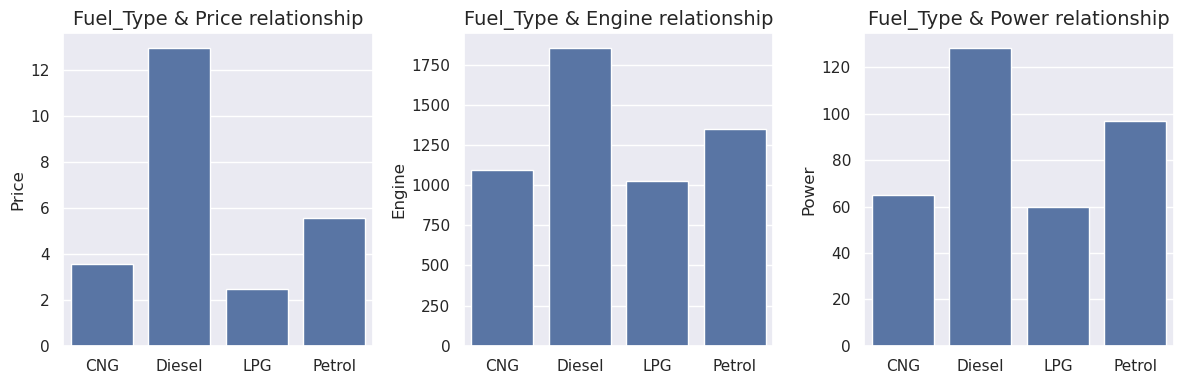

In [40]:
plt.figure(figsize=(12,4))
sns.set(font_scale=1)
plt.subplot(1,3,1)
sns.barplot(x=fuel_type_filter.Fuel_Type, y=fuel_type_filter.Price)
plt.title("Fuel_Type & Price relationship", fontsize=14), plt.xlabel("")
plt.subplot(1,3,2)
sns.barplot(x=fuel_type_filter.Fuel_Type, y=fuel_type_filter.Engine)
plt.title("Fuel_Type & Engine relationship", fontsize=14), plt.xlabel("")
plt.subplot(1,3,3)
sns.barplot(x=fuel_type_filter.Fuel_Type, y=fuel_type_filter.Power)
plt.title("Fuel_Type & Power relationship", fontsize=14), plt.xlabel("")
plt.tight_layout()
plt.show()

In [41]:
df.head()

Location  Year  Kilometers_Driven Fuel_Type Transmission Owner_Type  \
0      Mumbai  2010              72000       CNG       Manual      First   
1        Pune  2015              41000    Diesel       Manual      First   
2     Chennai  2011              46000    Petrol       Manual      First   
3     Chennai  2012              87000    Diesel       Manual      First   
4  Coimbatore  2013              40670    Diesel    Automatic     Second   

   Mileage  Engine   Power  Seats  Price    Brand                       Model  
0   35.378   998.0   58.16    5.0   1.75   Maruti             Wagon R LXI CNG  
1   19.670  1582.0  126.20    5.0  12.50  Hyundai    Creta 1.6 CRDi SX Option  
2   18.200  1199.0   88.70    5.0   4.50    Honda                      Jazz V  
3   20.770  1248.0   88.76    7.0   6.00   Maruti                  Ertiga VDI  
4   15.200  1968.0  140.80    5.0  17.74     Audi  A4 New 2.0 TDI Multitronic

### Correlation Between Numerical Features

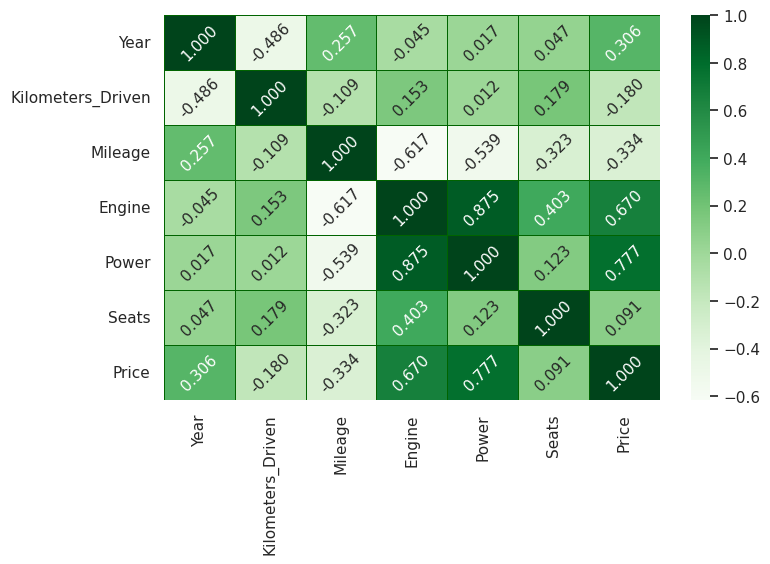

In [42]:
cor = df.iloc[:, [1,2,6,7,8,9,10]].corr()

plt.figure(figsize=(8,5))
sns.heatmap(cor, annot=True, linewidths=0.4, linecolor="darkgreen",
            annot_kws={'size': 11, 'rotation': 45}, fmt='.3f', cmap="Greens")
plt.show()

### Encoding Categorical Variable Values to Numerical Values

In [43]:
df.head(3)

Location  Year  Kilometers_Driven Fuel_Type Transmission Owner_Type  \
0   Mumbai  2010              72000       CNG       Manual      First   
1     Pune  2015              41000    Diesel       Manual      First   
2  Chennai  2011              46000    Petrol       Manual      First   

   Mileage  Engine   Power  Seats  Price    Brand                     Model  
0   35.378   998.0   58.16    5.0   1.75   Maruti           Wagon R LXI CNG  
1   19.670  1582.0  126.20    5.0  12.50  Hyundai  Creta 1.6 CRDi SX Option  
2   18.200  1199.0   88.70    5.0   4.50    Honda                    Jazz V

In [44]:
df["Year"] = df.Year.apply(lambda x: 2020 - x)

In [45]:
data = pd.get_dummies(data=df, columns=["Fuel_Type", "Owner_Type", "Seats"])

In [46]:
# 1 for Manual and 0 for Automatic
le = LabelEncoder()
data["Transmission"] = le.fit_transform(data["Transmission"])

In [47]:
target_encoder = TargetEncoder()

data["Location"] = target_encoder.fit_transform(data["Location"], data["Price"])
data["Brand"] = target_encoder.fit_transform(data["Brand"], data["Price"])
data["Model"] = target_encoder.fit_transform(data["Model"], data["Price"])

### Standardization

In [48]:
scaler = StandardScaler()
data.iloc[:, [0,1,2,4,5,6,7,8,9]] = scaler.fit_transform(data.iloc[:, [0,1,2,4,5,6,7,8,9]])

In [49]:
data.head(3)

Location      Year  Kilometers_Driven  Transmission   Mileage    Engine  \
0 -0.069365  1.130404           0.652006             1  3.726321 -1.050778   
1 -0.956998 -0.494308          -0.529564             1  0.253725 -0.059671   
2 -0.597637  0.805461          -0.338988             1 -0.071251 -0.709660   

      Power     Price     Brand     Model  ...  Owner_Type_Second  \
0 -1.034877 -0.721076 -0.608170 -1.178233  ...                  0   
1  0.242384  0.279290 -0.481720  0.523536  ...                  0   
2 -0.461574 -0.465168 -0.501212 -0.152120  ...                  0   

   Owner_Type_Third  Seats_2.0  Seats_4.0  Seats_5.0  Seats_6.0  Seats_7.0  \
0                 0          0          0          1          0          0   
1                 0          0          0          1          0          0   
2                 0          0          0          1          0          0   

   Seats_8.0  Seats_9.0  Seats_10.0  
0          0          0           0  
1          0          0           0  
2          0          0           0  

[3 rows x 26 columns]

### Split (train/test)

In [50]:
y = data["Price"]
X = data.drop("Price", axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)

### Model Building

In [51]:
model_list = [GradientBoostingRegressor(), XGBRegressor(), MLPRegressor(), CatBoostRegressor(verbose=False),
              AdaBoostRegressor(), HistGradientBoostingRegressor()]

RMSE_list = []
r_list = []

for model_name in model_list: 
    model = model_name.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
    r_score = r2_score(y_test, y_pred)
    
    RMSE_list.append(RMSE)
    r_list.append(r_score)

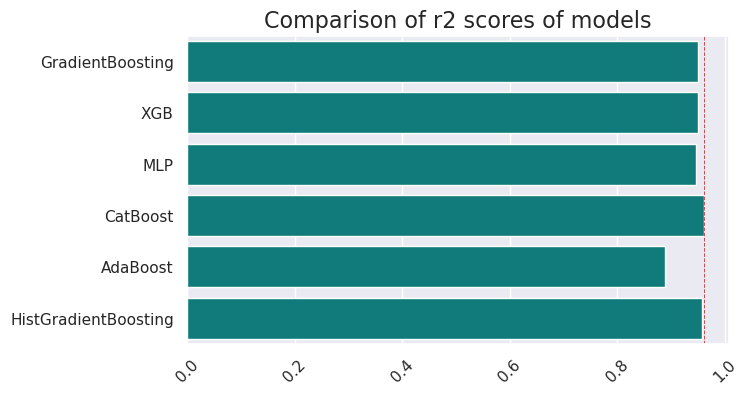

In [52]:
models = ["GradientBoosting", "XGB", "MLP", "CatBoost", "AdaBoost", "HistGradientBoosting"]

plt.figure(figsize=(7,4))
sns.barplot(x=r_list, y=models, color="#008b8b")
plt.xticks(rotation=45)
plt.axvline(x=0.9603, lw=0.7, color="r", ls="--")
plt.title("Comparison of r2 scores of models", fontsize=16)
plt.show()

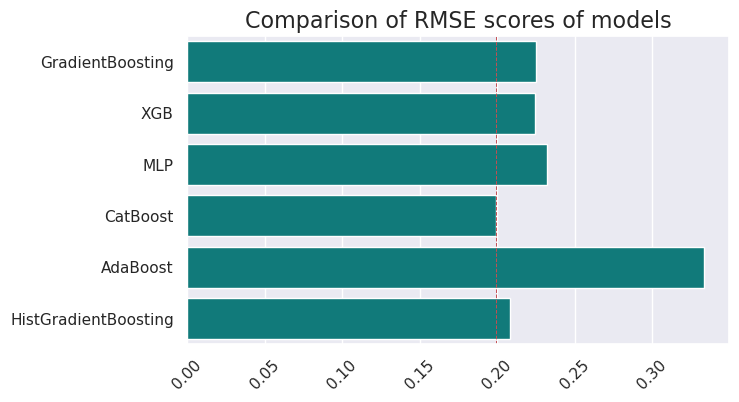

In [53]:
plt.figure(figsize=(7,4))
sns.barplot(x=RMSE_list, y=models, color="#008b8b")
plt.xticks(rotation=45)
plt.axvline(x=0.1993, lw=0.7, color="r", ls="--")
plt.title("Comparison of RMSE scores of models", fontsize=16)
plt.show()

### Feature Importance

In [54]:
final_model = CatBoostRegressor(depth=8, l2_leaf_reg=4, num_trees=1000, verbose=False).fit(X_train, y_train)
y_pred = final_model.predict(X_test)
print(f"r2 score: {r2_score(y_test, y_pred)}")
print(f"RMSE    : {np.sqrt(mean_squared_error(y_test, y_pred))}")

r2 score: 0.9625703847293271
RMSE    : 0.1937894160921602


In [55]:
feature_importance = pd.DataFrame(final_model.feature_importances_, index=X_train.columns, columns=["importance"])
feature_importance = feature_importance.sort_values(by="importance", ascending=False)
feature_importance.head()

importance
Model               43.822930
Power               14.673279
Year                14.279094
Brand                6.063925
Kilometers_Driven    5.123019

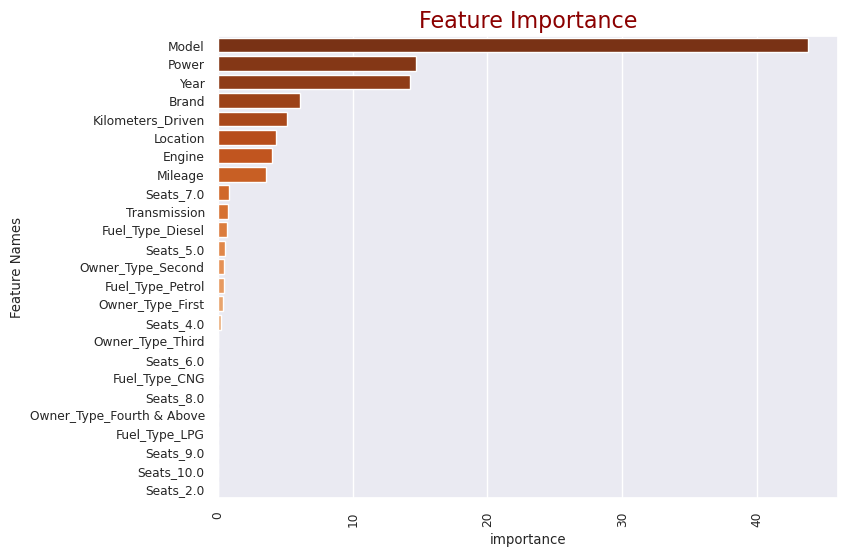

In [56]:
plt.figure(figsize=(8,6))
sns.set(font_scale=0.8)
sns.barplot(y=feature_importance.index, x=feature_importance.importance, palette="Oranges_r")
plt.title("Categories & Counts", fontsize=16, color="darkred")
plt.ylabel("Feature Names")
plt.title("Feature Importance", fontsize=16)
plt.xticks(rotation=90)
plt.show()